In [ ]:
!pip install segmentation_models

In [2]:
import segmentation_models as sm 
import tensorflow as tf
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from skimage.io import imread,imsave

Segmentation Models: using `keras` framework.


In [3]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [4]:
os.chdir("/content/drive/MyDrive/Chips")

In [5]:
image_names = glob.glob("Images/"+"*.tif")
image_names.sort()
images = [imread(image) for image in image_names] 
image_dataset = np.array(images)

In [6]:
print(image_dataset.shape)

(228, 128, 128, 3)


In [7]:
mask_names = glob.glob("Masks/"+"*.tif")
mask_names.sort()
masks = [imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)

In [8]:
print(mask_dataset.shape)
np.unique(mask_dataset)

(228, 128, 128)


array([0, 1], dtype=uint16)

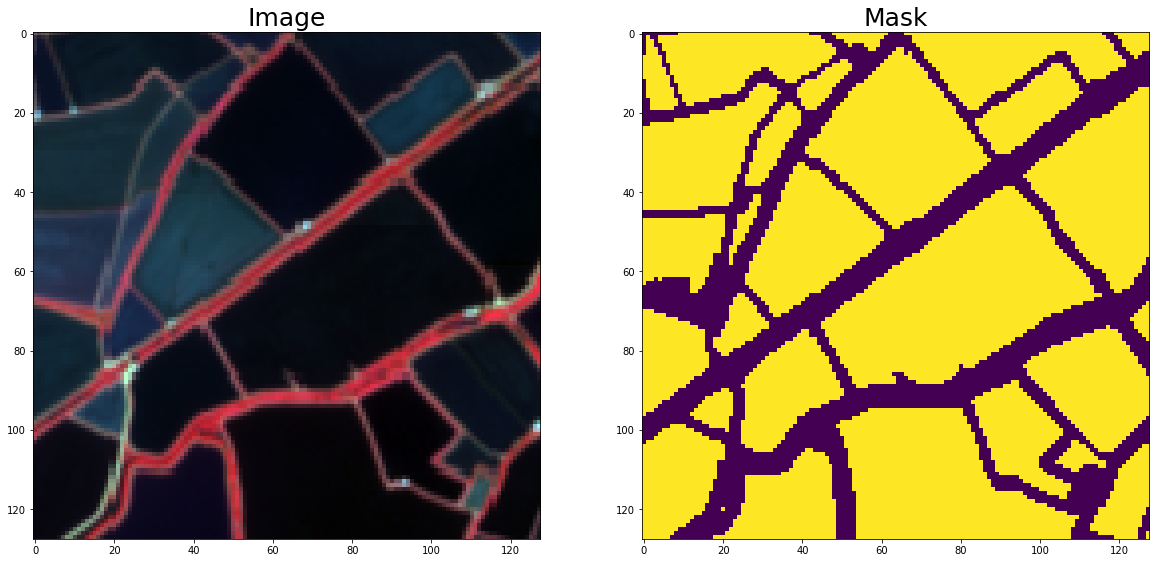

In [11]:
import random
img_number = random.randint(0, len(image_dataset)-1)
img = image_dataset[img_number]
img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
mask = mask_dataset[img_number]
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.title('Image',size = 25)
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Mask',size = 25)
plt.imshow(mask)
plt.show()

In [12]:
num_classes=2

In [13]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(mask_dataset, num_classes=num_classes)

In [14]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(image_dataset, train_masks_cat, test_size = 0.25)

In [15]:
X1=preprocess_input(X1)
X_test=preprocess_input(X_test)

In [16]:
IMG_HEIGHT = X1.shape[1]
IMG_WIDTH  = X1.shape[2]
IMG_CHANNELS = X1.shape[3]

In [17]:
print(X1.shape)

(171, 128, 128, 3)


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
img_data_gen_args = dict(
                    #  width_shift_range=0.3,
                    #  height_shift_range=0.3,
                    #  shear_range=0.5,
#                      zoom_range=0.3,
                     rotation_range=45,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(
                    #  width_shift_range=0.3,
                    #  height_shift_range=0.3,
                    #  shear_range=0.5,
#                      zoom_range=0.3,
                     rotation_range=45,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     ) #Binarize the output again.

In [20]:
seed=24
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X1, augment=True, seed=seed)
image_generator = image_data_generator.flow(X1, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

In [ ]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y1, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y1, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [22]:
def my_image_mask_generator(image_generator, mask_generator,num_classes):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
#         img, mask = preprocess_data(image, mask, num_classes)
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator,num_classes)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator,num_classes)

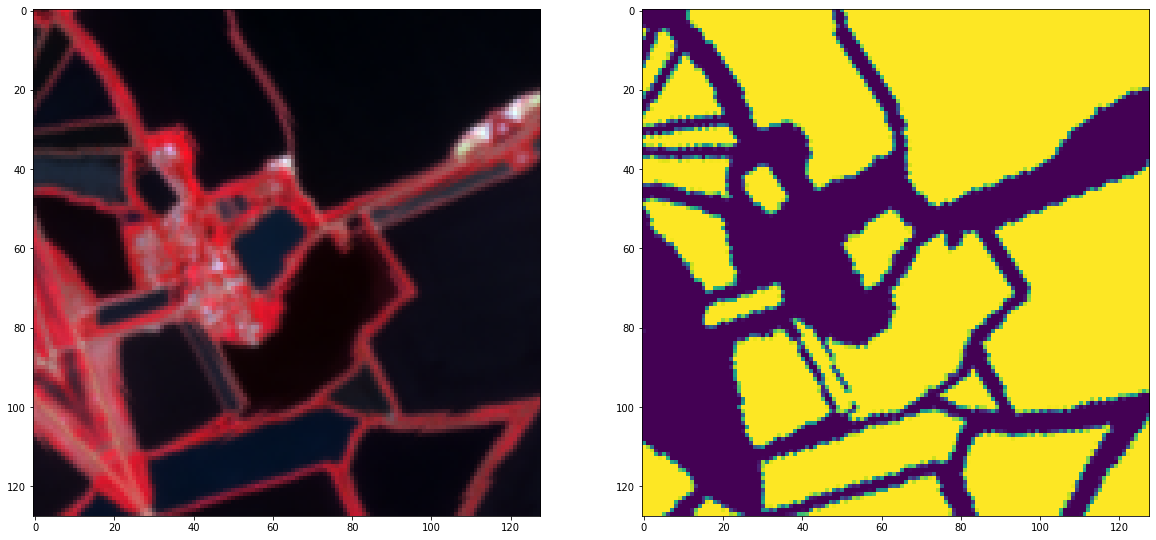

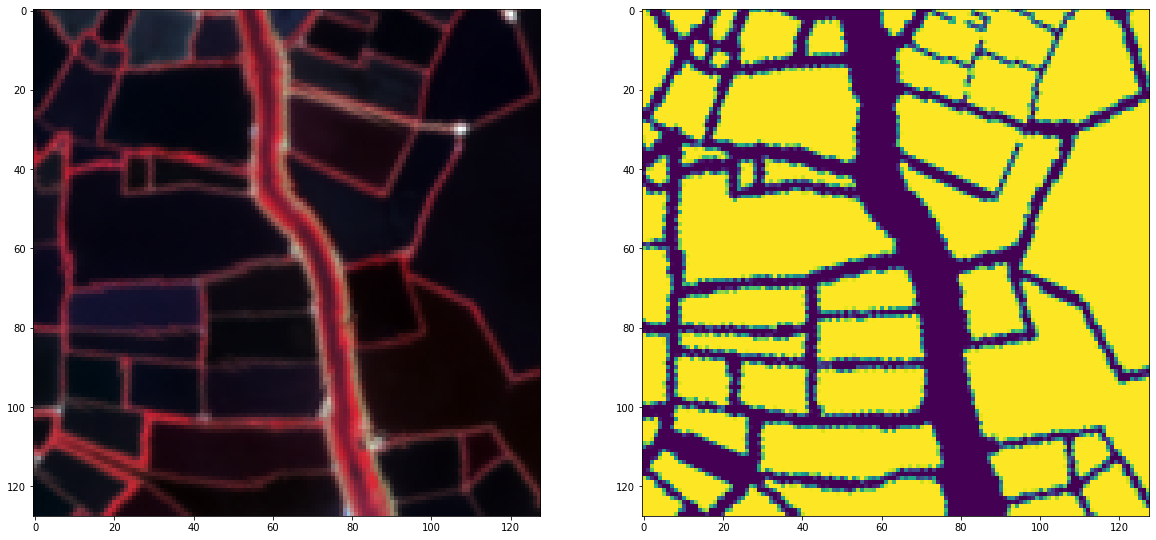

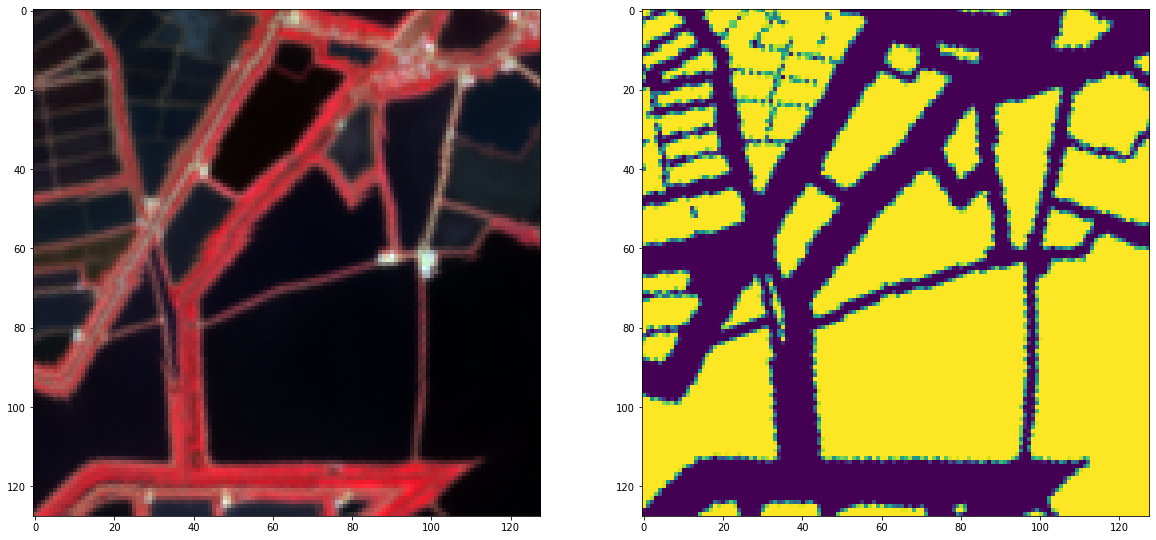

In [28]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,3):
    image = x[i]
    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    mask = y[i]
    plt.figure(figsize=(20, 20))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,1])
    plt.show()

batch_size = 16
steps_per_epoch = 3*(len(image_dataset))//batch_size

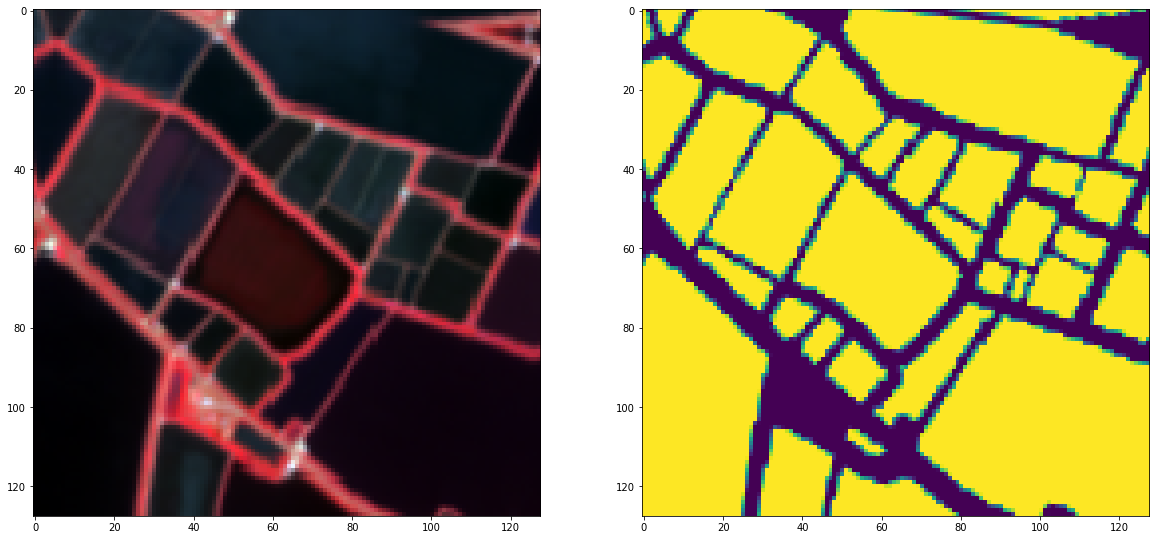

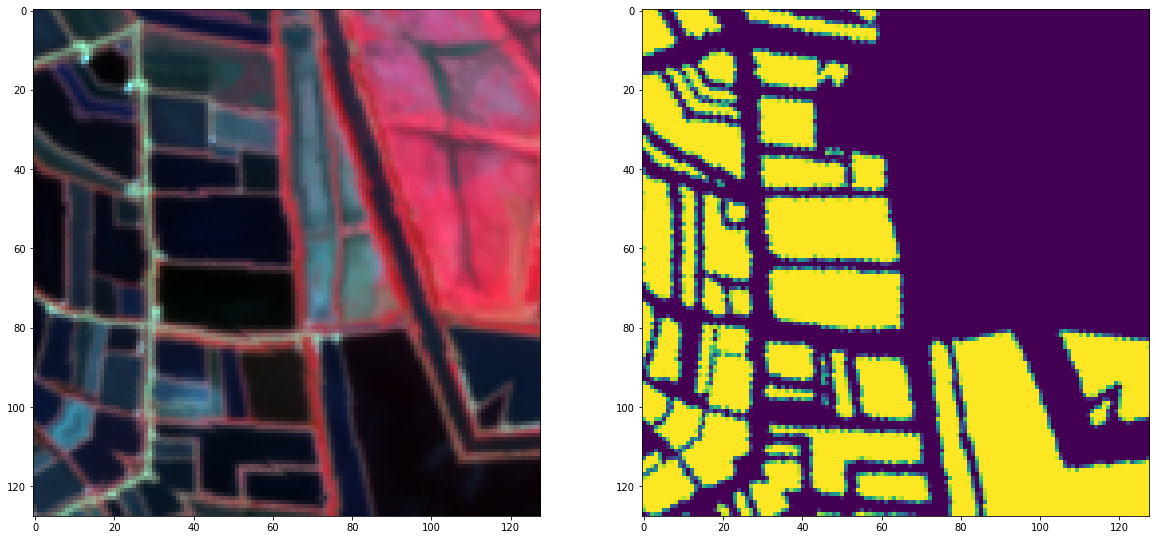

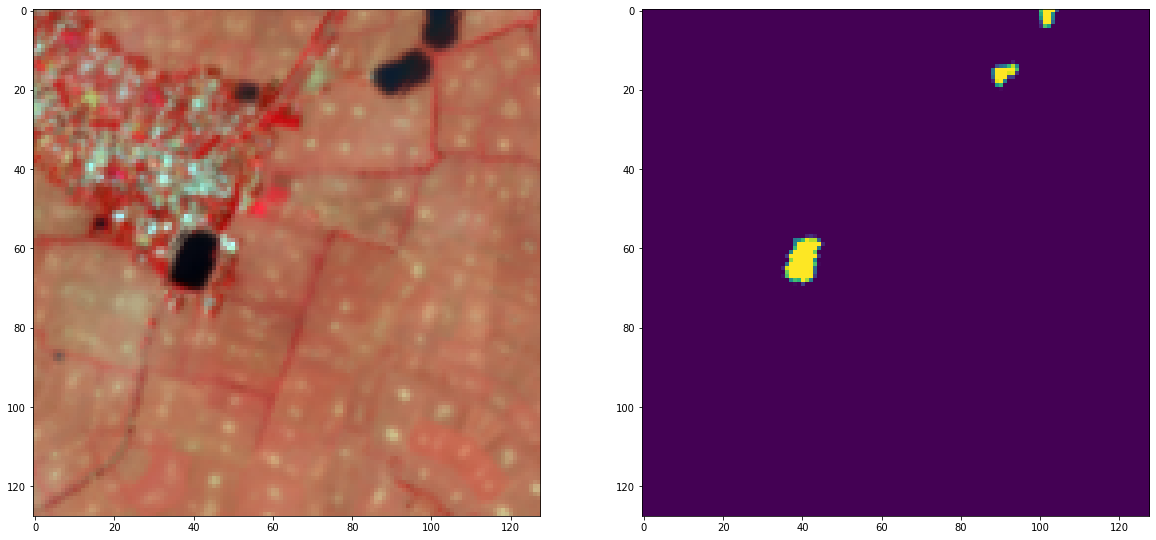

In [32]:
x = valid_img_generator.next()
y = valid_mask_generator.next()
for i in range(0,3):
    image = x[i]
    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    mask = y[i]
    plt.figure(figsize=(20, 20))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,1])
    plt.show()

In [24]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [25]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=num_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
print(model.input_shape)

85521592/85521592 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

In [26]:
history=model.fit(my_generator,
                  steps_per_epoch=steps_per_epoch,
          epochs=20,
#           verbose=1,
          validation_data=validation_datagen,
          validation_steps=20
)

Epoch 1/20
42/42 [==============================] - 33s 416ms/step - loss: 0.3075 - iou_score: 0.7150 - val_loss: 1.5966 - val_iou_score: 0.3172
Epoch 2/20
42/42 [==============================] - 12s 299ms/step - loss: 0.2036 - iou_score: 0.8253 - val_loss: 0.6770 - val_iou_score: 0.4497
Epoch 3/20
42/42 [==============================] - 14s 337ms/step - loss: 0.1818 - iou_score: 0.8456 - val_loss: 1.0557 - val_iou_score: 0.5271
Epoch 4/20
42/42 [==============================] - 14s 337ms/step - loss: 0.1888 - iou_score: 0.8397 - val_loss: 0.1961 - val_iou_score: 0.8326
Epoch 5/20
42/42 [==============================] - 14s 340ms/step - loss: 0.1865 - iou_score: 0.8443 - val_loss: 0.2842 - val_iou_score: 0.8019
Epoch 6/20
42/42 [==============================] - 12s 297ms/step - loss: 0.1808 - iou_score: 0.8453 - val_loss: 0.1905 - val_iou_score: 0.8464
Epoch 7/20
42/42 [==============================] - 14s 336ms/step - loss: 0.1745 - iou_score: 0.8546 - val_loss: 0.2084 - val_iou

In [27]:
history.history.keys()

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])

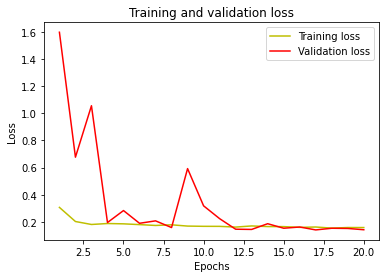

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

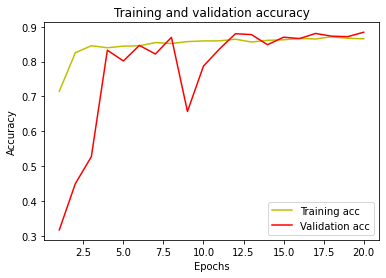

In [29]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
model.save('/content/drive/MyDrive/Models/'+'waterbodies_10_epochs_resnet34_backbone_IOU_88.hdf5')

In [33]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Models/waterbodies_10_epochs_resnet34_backbone_IOU_88.hdf5", compile=False)

In [44]:
test_image_batch, test_mask_batch = validation_datagen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

1/1 [==============================] - 1s 1s/step


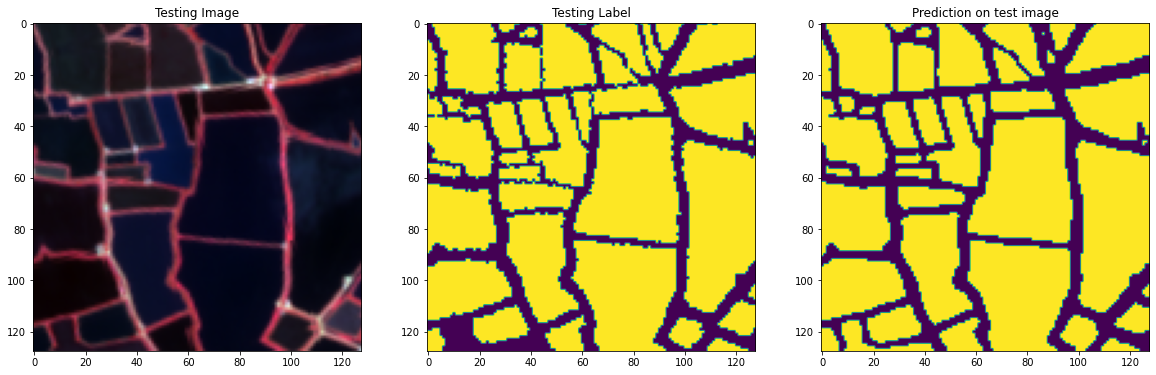

In [49]:
img_num = random.randint(0, test_image_batch.shape[0]-1)
image = test_image_batch[img_num]
image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()